<center>
    <img src="https://gitlab.com/ibm/skills-network/courses/placeholder101/-/raw/master/labs/module%201/images/IDSNlogo.png" width="300" alt="cognitiveclass.ai logo"  />
</center>


# **Space X  Falcon 9 First Stage Landing Prediction**


## Assignment:  Machine Learning Prediction


Estimated time needed: **60** minutes


Space X advertises Falcon 9 rocket launches on its website with a cost of 62 million dollars; other providers cost upward of 165 million dollars each, much of the savings is because Space X can reuse the first stage. Therefore if we can determine if the first stage will land, we can determine the cost of a launch. This information can be used if an alternate company wants to bid against space X for a rocket launch.   In this lab, you will create a machine learning pipeline  to predict if the first stage will land given the data from the preceding labs.


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/landing\_1.gif)


Several examples of an unsuccessful landing are shown here:


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/crash.gif)


Most unsuccessful landings are planed. Space X; performs a controlled landing in the oceans.


## Objectives


Perform exploratory  Data Analysis and determine Training Labels

*   create a column for the class
*   Standardize the data
*   Split into training data and test data

\-Find best Hyperparameter for SVM, Classification Trees and Logistic Regression

*   Find the method performs best using test data


***


## Import Libraries and Define Auxiliary Functions


We will import the following libraries for the lab


In [1]:
# Pandas is a software library written for the Python programming language for data manipulation and analysis.
import pandas as pd
# NumPy is a library for the Python programming language, adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays
import numpy as np
# Matplotlib is a plotting library for python and pyplot gives us a MatLab like plotting framework. We will use this in our plotter function to plot data.
import matplotlib.pyplot as plt
#Seaborn is a Python data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics
import seaborn as sns
# Preprocessing allows us to standarsize our data
from sklearn import preprocessing
# Allows us to split our data into training and testing data
from sklearn.model_selection import train_test_split
# Allows us to test parameters of classification algorithms and find the best one
from sklearn.model_selection import GridSearchCV
# Logistic Regression classification algorithm
from sklearn.linear_model import LogisticRegression
# Support Vector Machine classification algorithm
from sklearn.svm import SVC
# Decision Tree classification algorithm
from sklearn.tree import DecisionTreeClassifier
# K Nearest Neighbors classification algorithm
from sklearn.neighbors import KNeighborsClassifier

This function is to plot the confusion matrix.


In [2]:
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['did not land', 'land']); ax.yaxis.set_ticklabels(['did not land', 'landed'])

## Load the dataframe


Load the data


In [3]:
data = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_2.csv")

# If you were unable to complete the previous lab correctly you can uncomment and load this csv

# data = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/dataset_part_2.csv')

data.head(100)

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6104.959412,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,86,2020-09-03,Falcon 9,15400.000000,VLEO,KSC LC 39A,True ASDS,2,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,2,B1060,-80.603956,28.608058,1
86,87,2020-10-06,Falcon 9,15400.000000,VLEO,KSC LC 39A,True ASDS,3,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,2,B1058,-80.603956,28.608058,1
87,88,2020-10-18,Falcon 9,15400.000000,VLEO,KSC LC 39A,True ASDS,6,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,5,B1051,-80.603956,28.608058,1
88,89,2020-10-24,Falcon 9,15400.000000,VLEO,CCAFS SLC 40,True ASDS,3,True,True,True,5e9e3033383ecbb9e534e7cc,5.0,2,B1060,-80.577366,28.561857,1


In [4]:
X = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_3.csv')

# If you were unable to complete the previous lab correctly you can uncomment and load this csv

# X = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/dataset_part_3.csv')

X.head(100)

,FlightNumber,PayloadMass,Flights,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,...,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062,GridFins_False,GridFins_True,Reused_False,Reused_True,Legs_False,Legs_True
0,1.0,6104.959412,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,2.0,525.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,3.0,677.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,4.0,500.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,5.0,3170.000000,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,86.0,15400.000000,2.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
86,87.0,15400.000000,3.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
87,88.0,15400.000000,6.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
88,89.0,15400.000000,3.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0


## TASK  1


Create a NumPy array from the column <code>Class</code> in <code>data</code>, by applying the method <code>to_numpy()</code>  then
assign it  to the variable <code>Y</code>,make sure the output is a  Pandas series (only one bracket df\['name of  column']).


In [5]:
Y=data['Class'].to_numpy()
type(Y)

numpy.ndarray

## TASK  2


Standardize the data in <code>X</code> then reassign it to the variable  <code>X</code> using the transform provided below.


In [6]:
# students get this 
transform = preprocessing.StandardScaler()

In [7]:
transform.fit(X)
X=transform.transform(X)
print(X)
type(X)

[[-1.71291154e+00 -1.94814463e-16 -6.53912840e-01 ... -8.35531692e-01
   1.93309133e+00 -1.93309133e+00]
 [-1.67441914e+00 -1.19523159e+00 -6.53912840e-01 ... -8.35531692e-01
   1.93309133e+00 -1.93309133e+00]
 [-1.63592675e+00 -1.16267307e+00 -6.53912840e-01 ... -8.35531692e-01
   1.93309133e+00 -1.93309133e+00]
 ...
 [ 1.63592675e+00  1.99100483e+00  3.49060516e+00 ...  1.19684269e+00
  -5.17306132e-01  5.17306132e-01]
 [ 1.67441914e+00  1.99100483e+00  1.00389436e+00 ...  1.19684269e+00
  -5.17306132e-01  5.17306132e-01]
 [ 1.71291154e+00 -5.19213966e-01 -6.53912840e-01 ... -8.35531692e-01
  -5.17306132e-01  5.17306132e-01]]


numpy.ndarray

We split the data into training and testing data using the  function  <code>train_test_split</code>.   The training data is divided into validation data, a second set used for training  data; then the models are trained and hyperparameters are selected using the function <code>GridSearchCV</code>.


## TASK  3


Use the function train_test_split to split the data X and Y into training and test data. Set the parameter test_size to  0.2 and random_state to 2. The training data and test data should be assigned to the following labels.


<code>X_train, X_test, Y_train, Y_test</code>


In [8]:
X_train, X_test, Y_train, Y_test=train_test_split(X,Y,test_size=0.2,random_state=2)

we can see we only have 18 test samples.


In [9]:
Y_test.shape

(18,)

## TASK  4


Create a logistic regression object  then create a  GridSearchCV object  <code>logreg_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [10]:
parameters ={'C':[0.01,0.1,1],
             'penalty':['l2'],
             'solver':['lbfgs']}

In [11]:
parameters ={"C":[0.01,0.1,1],'penalty':['l2'], 'solver':['lbfgs']}# l1 lasso l2 ridge
lr=LogisticRegression()
logreg_cv=GridSearchCV(lr,parameters,cv=10)
logreg_cv.fit(X_train,Y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1], 'penalty': ['l2'],
                         'solver': ['lbfgs']})

We output the <code>GridSearchCV</code> object for logistic regression. We display the best parameters using the data attribute <code>best_params\_</code> and the accuracy on the validation data using the data attribute <code>best_score\_</code>.


In [12]:
print("Logistic Regression Model")
print("tuned hyperparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

Logistic Regression Model
tuned hyperparameters :(best parameters)  {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.8464285714285713


## TASK  5


Calculate the accuracy on the test data using the method <code>score</code>:


In [13]:
acc_test_LR=logreg_cv.score(X_test,Y_test)
print("LR's accuracy on test data:",acc_test_LR)

LR's accuracy on test data: 0.8333333333333334


Lets look at the confusion matrix:


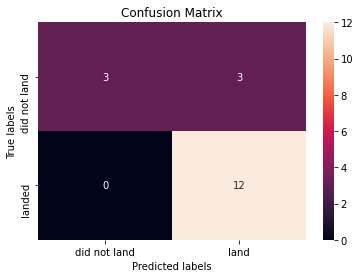

In [14]:
yhat=logreg_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

Examining the confusion matrix, we see that logistic regression can distinguish between the different classes.  We see that the major problem is false positives.


## TASK  6


Create a support vector machine object then  create a  <code>GridSearchCV</code> object  <code>svm_cv</code> with cv - 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [15]:
parameters = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),
              'C': np.logspace(-3, 3, 5),
              'gamma':np.logspace(-3, 3, 5)}
svm = SVC()

In [16]:
parameters = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'), 'C': np.logspace(-3, 3, 5), 'gamma':np.logspace(-3, 3, 5)}
svm_cv=GridSearchCV(svm,parameters,cv=10)
svm_cv.fit(X_train,Y_train)

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'gamma': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'kernel': ('linear', 'rbf', 'poly', 'rbf', 'sigmoid')})

In [17]:
print("SVM Model")
print("tuned hyperparameters :(best parameters) ",svm_cv.best_params_)
print("accuracy :",svm_cv.best_score_)

SVM Model
tuned hyperparameters :(best parameters)  {'C': 1.0, 'gamma': 0.03162277660168379, 'kernel': 'sigmoid'}
accuracy : 0.8482142857142856


## TASK  7


Calculate the accuracy on the test data using the method <code>score</code>:


In [18]:
acc_test_SVM=svm_cv.score(X_test,Y_test)
print("SVM's accuracy on test data:",acc_test_SVM)

SVM's accuracy on test data: 0.8333333333333334


We can plot the confusion matrix


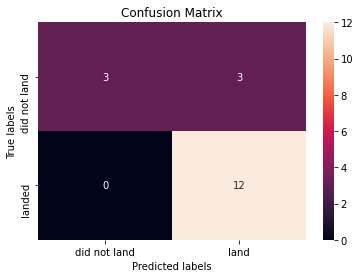

In [19]:
yhat=svm_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

## TASK  8


Create a decision tree classifier object then  create a  <code>GridSearchCV</code> object  <code>tree_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [20]:
parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}

tree = DecisionTreeClassifier()

In [21]:
parameters = {'criterion': ['gini', 'entropy'],'splitter': ['best', 'random'],'max_depth': [2*n for n in range(1,10)],'max_features': ['auto', 'sqrt'],
              'min_samples_leaf': [1, 2, 4],'min_samples_split': [2, 5, 10]}
tree_cv=GridSearchCV(tree,parameters,cv=10)
tree_cv.fit(X_train,Y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'splitter': ['best', 'random']})

In [22]:
print("Decision Tree Model")
print("tuned hyperparameters :(best parameters) ",tree_cv.best_params_)
print("accuracy :",tree_cv.best_score_)

Decision Tree Model
tuned hyperparameters :(best parameters)  {'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 5, 'splitter': 'random'}
accuracy : 0.8875


## TASK  9


Calculate the accuracy of tree_cv on the test data using the method <code>score</code>:


In [23]:
acc_test_DT=tree_cv.score(X_test,Y_test)
print("DT's accuracy on test data:",acc_test_DT)

DT's accuracy on test data: 0.6666666666666666


We can plot the confusion matrix


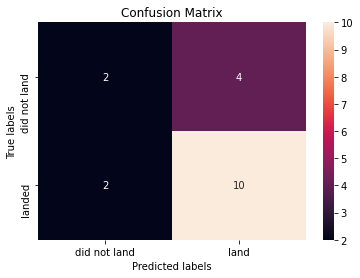

In [24]:
yhat = tree_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

## TASK  10


Create a k nearest neighbors object then  create a  <code>GridSearchCV</code> object  <code>knn_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [25]:
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

KNN = KNeighborsClassifier()

In [26]:
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}
knn_cv=GridSearchCV(KNN,parameters,cv=10)
knn_cv.fit(X_train,Y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'p': [1, 2]})

In [27]:
print("K-Nearest Neighbors Model")
print("tuned hyperparameters :(best parameters) ",knn_cv.best_params_)
print("accuracy :",knn_cv.best_score_)

K-Nearest Neighbors Model
tuned hyperparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 10, 'p': 1}
accuracy : 0.8482142857142858


## TASK  11


Calculate the accuracy of tree_cv on the test data using the method <code>score</code>:


In [28]:
acc_test_KNN=knn_cv.score(X_test,Y_test)
print("KNN's accuracy on test data:",acc_test_KNN)

KNN's accuracy on test data: 0.8333333333333334


We can plot the confusion matrix


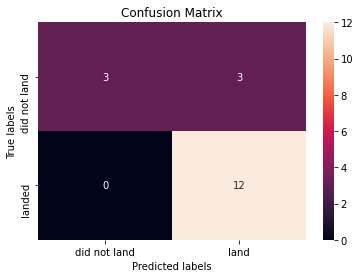

In [29]:
yhat = knn_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

## TASK  12


Find the method performs best:


In [30]:
from sklearn import metrics
from sklearn.metrics import jaccard_score, classification_report, f1_score

###### Jaccard's, F1 scores and Classification Report

In [31]:
models=(logreg_cv, svm_cv, tree_cv, knn_cv)
model_names=('Logistic Regression','SVM', 'Decision Tree', 'KNN')
for i in range (0,4):
    model=models[i]
    yhat=model.predict(X_test)
    print(model_names[i])
    print("Jaccard's score:", jaccard_score(Y_test, yhat, pos_label=1))
    print("F1 score:", f1_score(Y_test, yhat, pos_label=1))
    print("Report:", classification_report(Y_test, yhat))

Logistic Regression
Jaccard's score: 0.8
F1 score: 0.888888888888889
Report:               precision    recall  f1-score   support

           0       1.00      0.50      0.67         6
           1       0.80      1.00      0.89        12

    accuracy                           0.83        18
   macro avg       0.90      0.75      0.78        18
weighted avg       0.87      0.83      0.81        18

SVM
Jaccard's score: 0.8
F1 score: 0.888888888888889
Report:               precision    recall  f1-score   support

           0       1.00      0.50      0.67         6
           1       0.80      1.00      0.89        12

    accuracy                           0.83        18
   macro avg       0.90      0.75      0.78        18
weighted avg       0.87      0.83      0.81        18

Decision Tree
Jaccard's score: 0.625
F1 score: 0.7692307692307692
Report:               precision    recall  f1-score   support

           0       0.50      0.33      0.40         6
           1       0.71  

#### The performances of prediction are exactly the same in most cases. The size of the test dataset is small and that is an issue to see differences. 
#### For small datasets, a more consistant out-of-sample evaluation is obtained by using Cross Validation, where each observation is used for both training and testing.

### CROSS VALIDATION

In [32]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

              precision    recall  f1-score   support

           0       0.88      0.50      0.64        30
           1       0.79      0.97      0.87        60

    accuracy                           0.81        90
   macro avg       0.84      0.73      0.76        90
weighted avg       0.82      0.81      0.79        90



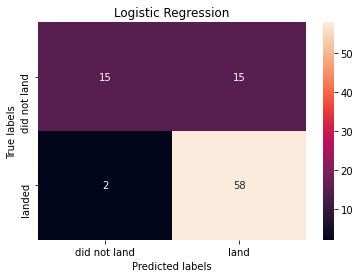

In [33]:
yhat=cross_val_predict(logreg_cv,X,Y,cv=4)
plot_confusion_matrix(Y,yhat)
plt.title(model_names[0])
print(classification_report(Y, yhat))

              precision    recall  f1-score   support

           0       0.72      0.60      0.65        30
           1       0.82      0.88      0.85        60

    accuracy                           0.79        90
   macro avg       0.77      0.74      0.75        90
weighted avg       0.78      0.79      0.78        90



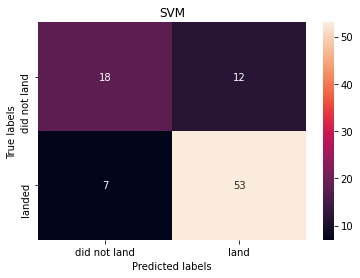

In [34]:
yhat=cross_val_predict(svm_cv,X,Y,cv=4)
plot_confusion_matrix(Y,yhat)
plt.title(model_names[1])
print(classification_report(Y, yhat))

              precision    recall  f1-score   support

           0       0.55      0.60      0.57        30
           1       0.79      0.75      0.77        60

    accuracy                           0.70        90
   macro avg       0.67      0.68      0.67        90
weighted avg       0.71      0.70      0.70        90



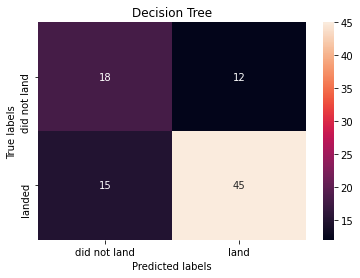

In [35]:
yhat=cross_val_predict(tree_cv,X,Y,cv=4)
plot_confusion_matrix(Y,yhat)
plt.title(model_names[2])
print(classification_report(Y, yhat))

              precision    recall  f1-score   support

           0       0.70      0.53      0.60        30
           1       0.79      0.88      0.83        60

    accuracy                           0.77        90
   macro avg       0.74      0.71      0.72        90
weighted avg       0.76      0.77      0.76        90



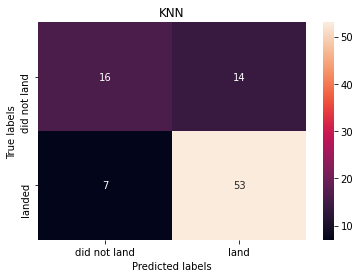

In [36]:
yhat=cross_val_predict(knn_cv,X,Y,cv=4)
plot_confusion_matrix(Y,yhat)
plt.title(model_names[3])
print(classification_report(Y, yhat))

#### Now we can see the differences between the models.
#### Let's get new performance indicators.
#### We notice that the accuracies are influenced by the unbalance number of samples of the 2 classes (2:1). We will obtain weighted indicators to have a more consistent result

In [37]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score

In [38]:
scoring = ['balanced_accuracy','jaccard_weighted','f1_weighted', 'precision_weighted', 'recall_weighted']
score_LR=cross_validate(logreg_cv,X,Y,cv=4,scoring=scoring)
sorted(score_LR.keys())

['fit_time',
 'score_time',
 'test_balanced_accuracy',
 'test_f1_weighted',
 'test_jaccard_weighted',
 'test_precision_weighted',
 'test_recall_weighted']

In [45]:
RESULTS_LR=pd.DataFrame(pd.DataFrame(score_LR).mean(axis=0))
RESULTS_LR.columns=['Log Reg']

In [44]:
score_SVM=cross_validate(svm_cv,X,Y,cv=4,scoring=scoring)
sorted(score_SVM.keys())

['fit_time',
 'score_time',
 'test_balanced_accuracy',
 'test_f1_weighted',
 'test_jaccard_weighted',
 'test_precision_weighted',
 'test_recall_weighted']

In [46]:
RESULTS_SVM=pd.DataFrame(pd.DataFrame(score_SVM).mean(axis=0))
RESULTS_SVM.columns=['SVM']

In [47]:
score_TREE=cross_validate(tree_cv,X,Y,cv=4,scoring=scoring)
sorted(score_TREE.keys())

['fit_time',
 'score_time',
 'test_balanced_accuracy',
 'test_f1_weighted',
 'test_jaccard_weighted',
 'test_precision_weighted',
 'test_recall_weighted']

In [48]:
RESULTS_TREE=pd.DataFrame(score_TREE).mean(axis=0)
RESULTS_TREE=pd.DataFrame(RESULTS_TREE)
RESULTS_TREE.columns=['Decision Tree']

In [49]:
score_KNN=cross_validate(knn_cv,X,Y,cv=4,scoring=scoring)
sorted(score_KNN.keys())

['fit_time',
 'score_time',
 'test_balanced_accuracy',
 'test_f1_weighted',
 'test_jaccard_weighted',
 'test_precision_weighted',
 'test_recall_weighted']

In [50]:
RESULTS_KNN=pd.DataFrame(score_KNN).mean(axis=0)
RESULTS_KNN=pd.DataFrame(RESULTS_KNN)
RESULTS_KNN.columns=['KNN']

In [73]:
RES=pd.concat([RESULTS_LR,RESULTS_SVM,RESULTS_TREE,RESULTS_KNN], axis=1)
RES

,Log Reg,SVM,Decision Tree,KNN
fit_time,0.131133,1.896287,6.419994,1.316412
score_time,0.002692,0.002823,0.002740,0.003968
test_balanced_accuracy,0.728869,0.740774,0.620536,0.705060
test_jaccard_weighted,0.669685,0.662502,0.491126,0.613603
test_f1_weighted,0.774086,0.778475,0.603554,0.741846
test_precision_weighted,0.858914,0.795364,0.789655,0.813812
test_recall_weighted,0.810771,0.790020,0.669466,0.767787


In [74]:
RESULTS=RES.transpose().round(decimals=2)
RESULTS

,fit_time,score_time,test_balanced_accuracy,test_jaccard_weighted,test_f1_weighted,test_precision_weighted,test_recall_weighted
Log Reg,0.13,0.0,0.73,0.67,0.77,0.86,0.81
SVM,1.90,0.0,0.74,0.66,0.78,0.80,0.79
Decision Tree,6.42,0.0,0.62,0.49,0.60,0.79,0.67
KNN,1.32,0.0,0.71,0.61,0.74,0.81,0.77


In [75]:
RESULTS=RESULTS.drop(columns=['score_time'])
RESULTS

,fit_time,test_balanced_accuracy,test_jaccard_weighted,test_f1_weighted,test_precision_weighted,test_recall_weighted
Log Reg,0.13,0.73,0.67,0.77,0.86,0.81
SVM,1.90,0.74,0.66,0.78,0.80,0.79
Decision Tree,6.42,0.62,0.49,0.60,0.79,0.67
KNN,1.32,0.71,0.61,0.74,0.81,0.77


In [76]:
k=len(RESULTS.columns)
col=RESULTS.columns
k

6

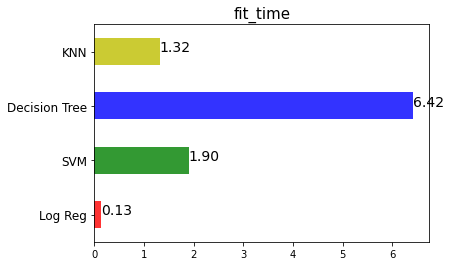

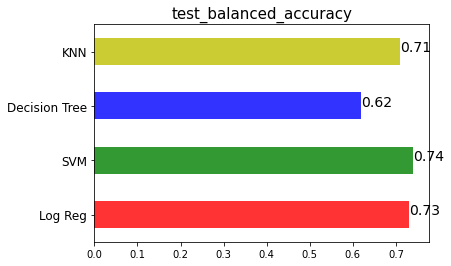

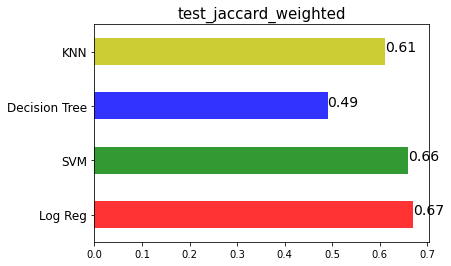

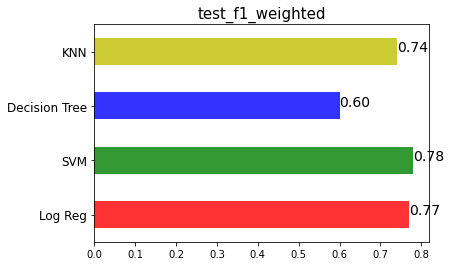

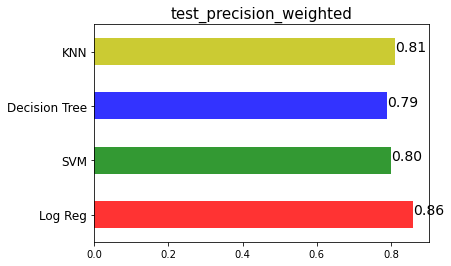

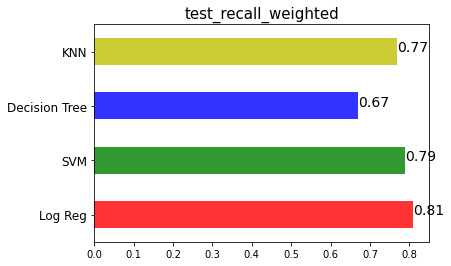

In [90]:
for i in range(0,k):
    RESULTS[col[i]].plot(kind='barh', color=list('rgby'), alpha=0.8)
    plt.title(RESULTS.columns[i], fontsize=15)
    plt.yticks(fontsize=12)
    for index, value in enumerate (RESULTS[col[i]]):
        plt.text (value, index, str("{:.2f}".format(value)), fontsize=14)
    plt.show()

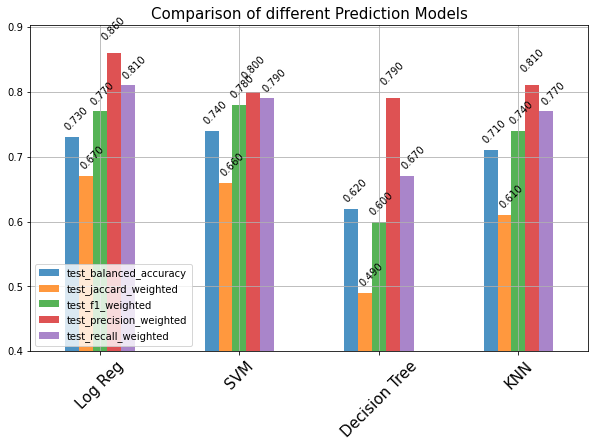

In [106]:
RESULTS[['test_balanced_accuracy','test_jaccard_weighted','test_f1_weighted','test_precision_weighted','test_recall_weighted']].plot(kind='bar', figsize=(10,6), alpha=0.8)
plt.title('Comparison of different Prediction Models', fontsize=15)
plt.legend(loc='lower left', fontsize=10)
plt.xticks(fontsize=15, rotation=45)
plt.grid()parameters = {'criterion': ['gini', 'entropy'],'splitter': ['best', 'random'],'max_depth': [2*n for n in range(1,10)],'max_features': ['auto', 'sqrt'],
              'min_samples_leaf': [1, 2, 4],'min_samples_split': [2, 5, 10]}
tree_cv=GridSearchCV(tree,parameters,cv=10)
tree_cv.fit(X_train,Y_train)
plt.ylim(0.4,)
plt.xlabel(None)
for index, value in enumerate (RESULTS['test_balanced_accuracy']):
    plt.text (index-0.27, value+0.01, str("{:.3f}".format(value)), rotation=45)
for index, value in enumerate (RESULTS['test_jaccard_weighted']):
    plt.text (index-0.15, value+0.01, str("{:.3f}".format(value)), rotation=45)
for index, value in enumerate (RESULTS['test_f1_weighted']):
    plt.text (index-0.08, value+0.01, str("{:.3f}".format(value)), rotation=45)
for index, value in enumerate (RESULTS['test_precision_weighted']):
    plt.text (index, value+0.02, str("{:.3f}".format(value)), rotation=45)
for index, value in enumerate (RESULTS['test_recall_weighted']):
    plt.text (index+0.15, value+0.01, str("{:.3f}".format(value)), rotation=45)
plt.show()

              precision    recall  f1-score   support

           0       0.40      0.93      0.56        30
           1       0.90      0.30      0.45        60

    accuracy                           0.51        90
   macro avg       0.65      0.62      0.51        90
weighted avg       0.73      0.51      0.49        90



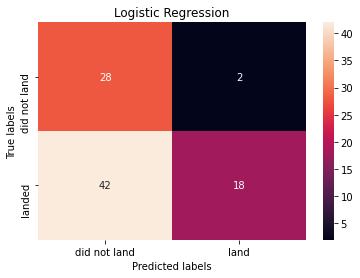

In [157]:
parameters ={"C":[0.01,0.1,1],'penalty':['l2'], 'solver':['lbfgs'], 'class_weight':[{0:0.98, 1:0.02}]}# l1 lasso l2 ridge
lr2=LogisticRegression()
logreg2_cv=GridSearchCV(lr2,parameters,cv=10)
logreg2_cv.fit(X_train,Y_train)
yhat=cross_val_predict(logreg2_cv,X,Y,cv=4)
plot_confusion_matrix(Y,yhat)
plt.title(model_names[0])
print(classification_report(Y, yhat))

              precision    recall  f1-score   support

           0       0.52      0.57      0.54        30
           1       0.77      0.73      0.75        60

    accuracy                           0.68        90
   macro avg       0.64      0.65      0.65        90
weighted avg       0.69      0.68      0.68        90



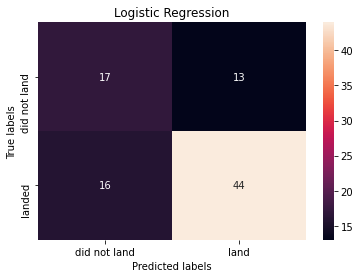

In [158]:
parameters = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'), 'C': np.logspace(-3, 3, 5), 'gamma':np.logspace(-3, 3, 5), 'class_weight':[{0:0.98, 1:0.02}]}
svm2_cv=GridSearchCV(svm,parameters,cv=10)
svm2_cv.fit(X_train,Y_train)
yhat=cross_val_predict(svm2_cv,X,Y,cv=4)
plot_confusion_matrix(Y,yhat)
plt.title(model_names[1])
print(classification_report(Y, yhat))

              precision    recall  f1-score   support

           0       0.45      0.47      0.46        30
           1       0.73      0.72      0.72        60

    accuracy                           0.63        90
   macro avg       0.59      0.59      0.59        90
weighted avg       0.64      0.63      0.63        90



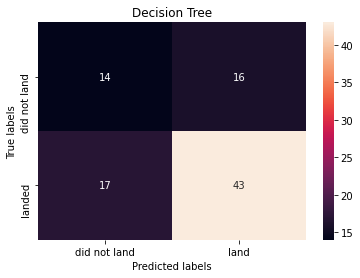

In [159]:
parameters = {'criterion': ['gini', 'entropy'],'splitter': ['best', 'random'],'max_depth': [2*n for n in range(1,10)],'max_features': ['auto', 'sqrt'],
              'min_samples_leaf': [1, 2, 4],'min_samples_split': [2, 5, 10], 'class_weight':[{0:0.98, 1:0.02}]}
tree2_cv=GridSearchCV(tree,parameters,cv=10)
tree2_cv.fit(X_train,Y_train)
yhat=cross_val_predict(tree2_cv,X,Y,cv=4)
plot_confusion_matrix(Y,yhat)
plt.title(model_names[2])
print(classification_report(Y, yhat))

## Authors

<a href="https://www.linkedin.com/in/joseph-s-50398b136/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDS0321ENSkillsNetwork26802033-2021-01-01">Joseph Santarcangelo</a> has a PhD in Electrical Engineering, his research focused on using machine learning, signal processing, and computer vision to determine how videos impact human cognition. Joseph has been working for IBM since he completed his PhD.


## Change Log


| Date (YYYY-MM-DD) | Version | Changed By    | Change Description      |
| ----------------- | ------- | ------------- | ----------------------- |
| 2021-08-31        | 1.1     | Lakshmi Holla | Modified markdown       |
| 2020-09-20        | 1.0     | Joseph        | Modified Multiple Areas |


Copyright © 2020 IBM Corporation. All rights reserved.
